In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.stats import linregress

## Define our Leath Cluster below ##

In [9]:
class Leath:
    def __init__(self, N=80, p=.6, animate=False):
        self.N = N
        self.p = p
        self.no_particles = 0
        self.perimeter = {}
        self.cluster = {}
        self.world = np.zeros((self.N, self.N), dtype=np.int8)
        self.reached_end = False
        self.stopped_growing = False
        self.seed_cluster()

        self.animate = animate
        if self.animate:
            self.fig, self.ax = plt.subplots()
            self.im = self.ax.imshow(self.world, cmap='GnBu')

    def seed_cluster(self):
        pt = (self.N // 2, self.N // 2)
        self.cluster[pt] = True
        self.add_perimeter(pt)
        self.world[pt] = 1
        self.no_particles = 1

    def reset(self):
        self.perimeter = {}
        self.cluster = {}
        self.world = np.zeros((self.N, self.N), dtype=np.int8)
        self.stopped_growing = False
        self.reached_end = False
        self.seed_cluster()
        if self.animate:
            self.fig, self.ax = plt.subplots()
            self.im = self.ax.imshow(self.world, cmap='GnBu')

    def simulate(self):
        self.reset()
        self.seed_cluster()
        while not self.stopped_growing:
            self.grow_cluster()
        return

    def add_perimeter(self, pt):
        """
        Given a point pt (tuple), add to a perimeter all 4 nearest neighbors that are not already in the cluster.
        """
        # Create list of four nearest neighbors
        nn = [(pt[0] + 1, pt[1]), (pt[0] - 1, pt[1]), (pt[0], pt[1] + 1), (pt[0], pt[1] - 1)]

        # Iterate through the points of the nearest neighbors and add them to the perimeter
        for p in nn:
            if p not in self.cluster and p not in self.perimeter:
                self.perimeter[p] = True

    def grow_cluster(self):
        """
        Iterate through each point in perimeter if uniform random [0,1] is less than p add perimeter point to cluster.
        Else mark point as inaccessible.
        Do something to keep cluster from leaving domain.
        """
        # Need a new list to store cluster points
        new_cluster_pts = []

        # Loop through the active points in the perimeter, add the point the cluster with probability p
        active_perimeter = [k for k, v in self.perimeter.items() if bool(v)]
        for pt in active_perimeter:
            if self.p >= np.random.rand():
                new_cluster_pts.append(pt)
            else:
                # self.cluster[pt] = False
                self.perimeter[pt] = False

        # Check if there are no new points being added to the cluster
        if len(new_cluster_pts) == 0:
            self.stopped_growing = True
            return False

        # Loop through the new cluster points and add their nearest neighbors to the perimeter
        for pt in new_cluster_pts:
            if pt[0] in range(0, self.N) and pt[1] in range(0, self.N):
                self.cluster[pt] = True
                self.perimeter[pt] = False
                self.no_particles += 1
                self.world[pt[1], pt[0]] = 1
                self.add_perimeter(pt)
            else:
                self.reached_end = True
                return False

    def animate_leath(self, display=False):
        plt.axis('off')
        anim = FuncAnimation(self.fig, self._animate, interval=100, frames=1000,
                             repeat=False)
        if display:
            plt.show()
        return anim

    def _animate(self, i):

        if leath.stopped_growing or leath.reached_end:
            return
        else:
            self.grow_cluster()

        self.im.set_data(self.world)
        self.ax.set_title(f'Leath Cluster at {i} Iterations')

    def distance_from_center_of_mass(self):
        # Loop through points in dictionary and create np array
        list_of_pts = list()
        for pt in self.cluster.keys():
            list_of_pts.append(pt)
        pts = np.array(list_of_pts, np.float32)

        # Compute center of mass adjusted distances
        cm_pts = pts - np.sum(pts, 0) / self.no_particles
        r = np.sqrt(np.square(cm_pts[:, 0]) + np.square(cm_pts[:, 1]))

        return r

## DLA Cluster Below ##

In [13]:
class DLA:
    def __init__(self, N=80, start_radius=3):
        self.N = N
        self.first_radius = start_radius
        self.start_radius = self.first_radius
        self.ring_size = self.N // 10
        self.max_radius = self.start_radius + self.ring_size

        self.cluster = {}
        self.world = np.zeros((N, N), dtype=np.int8)
        self.num_particles = 0
        self.stop_flag = False

    def seed_particle(self):
        """ Seeds the world with a single particle in the center"""
        pt = (self.N // 2, self.N // 2)
        self.cluster[(self.N // 2, self.N // 2)] = 1
        self.num_particles += 1
        self.world[pt] = self.num_particles
        
    def _reset(self):
        """ Resets the DLA cluster """
        self.start_radius = self.first_radius
        self.ring_size = self.N // 10
        self.max_radius = self.start_radius + self.ring_size

        self.cluster = {}
        self.world = np.zeros((self.N, self.N), dtype=np.int8)
        self.num_particles = 0
        self.stop_flag = False

    def simulate(self):
        """ Runs a DLA cluster until it reaches its end condition"""
        self._reset()
        self.seed_particle()
        while not self.stop_flag:
            self.add_particle()

    def add_particle(self):
        """ Performs a step in the DLA algorithm """
        if self.start_radius <= self.N // 2:
            while True:
                init_position = self._find_initial_position()
                # Random walk was a success and a particle was added
                if self.random_walk(init_position):
                    return
                # Restart the random walk with a new initial point
                else:
                    pass
        else:
            self.stop_flag = True

    def random_walk(self, p):
        """ Performs a random walk for a particle randomly placed on the circumference of a circle """
        # Starting point of the particle
        x, y = p

        # Repeat the random walk until
        while True:
            r_squared = np.square(x - self.N // 2) + np.square(y - self.N // 2)
            r = 1 + np.int(np.sqrt(r_squared))

            # If the particle is already in the cluster, try again and release a new particle
            if self.world[y, x] == 1:
                return False

            # Start new walker because it's not going the right direction
            if r > self.max_radius:
                return False

            # The walk has hit the cluster, so add the particle and increment the starting radius
            neighbor_sum = self._neighbor_sum((x, y))
            if r < self.N // 2 and neighbor_sum > 0:
                self.num_particles += 1
                self.world[y, x] = 1
                self.cluster[(x, y)] = 1
                if r >= self.start_radius:
                    self.start_radius += 2
                self.max_radius = self.start_radius + self.ring_size
                return True

            # Particle still hasn't hit the cluster, take a step
            else:
                random_number = np.random.randint(4)
                if random_number == 0 and x in range(2, self.N - 2):
                    x += 1
                elif random_number == 1 and x in range(2, self.N - 2):
                    x -= 1
                elif random_number == 2 and y in range(2, self.N - 2):
                    y += 1
                elif random_number == 3 and y in range(2, self.N - 2):
                    y -= 1

    def _find_initial_position(self):
        """ Finds the random initial position of the new random walker """
        theta = 2 * np.pi * np.random.rand()
        x = self.N // 2 + np.int(self.start_radius * np.cos(theta))
        y = self.N // 2 + np.int(self.start_radius * np.sin(theta))
        return x, y

    def _neighbor_sum(self, pt):
        """ Sums the 4 nearest neighbors around a point """
        x, y = pt
        right = self.world[y, x + 1]
        left = self.world[y, x - 1]
        up = self.world[y - 1, x]
        down = self.world[y + 1, x]
        s = right + left + up + down
        return s
    
    def distance_from_center_of_mass(self):
        # Loop through points in dictionary and create np array
        list_of_pts = list()
        for pt in self.cluster.keys():
            list_of_pts.append(pt)
        pts = np.array(list_of_pts, np.float32)

        # Compute center of mass adjusted distances
        cm_pts = pts - np.sum(pts, 0) / self.num_particles
        r = np.sqrt(np.square(cm_pts[:, 0]) + np.square(cm_pts[:, 1]))

        return r

## Problem 1 - Leath Clusters ##

### 5 Leath Clusters, p = 0.5927 ###

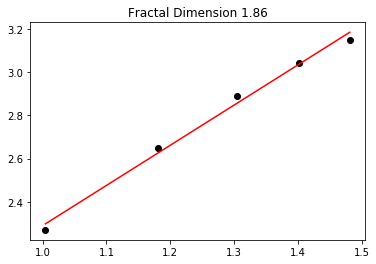

In [6]:
# Values for leath cluster
N = 101
p = 0.5927

# Initialize a leath cluster
leath = Leath(N, p=p, animate=False)

# Initialize fit and simulation values
max_clusters = 5
cluster_no = 0
no_bins = 5
bin_count = np.zeros(no_bins, dtype=np.int32)
bin_edges = np.zeros([max_clusters, no_bins+1], dtype=np.float32)
min_size = 0.15 * N/2
max_size = 0.65 * N/2

# Grow total_clusters Different Clusters
while cluster_no < max_clusters:
    # run a Leath simulation
    leath.simulate()
    while not leath.reached_end:
        leath.simulate()
    # Compute distance from center of mass, and add distances to a histogram
    radii = leath.distance_from_center_of_mass()
    cnt, bin_edges[cluster_no, :] = np.histogram(radii, bins=no_bins, range=(min_size, max_size))
    bin_count += np.cumsum(cnt)

    cluster_no += 1

# Take the average count and bin centers across all clusters
avg_bin_count = bin_count / max_clusters
avg_bin_edge = np.mean(bin_edges, 0)
avg_bin_mid = (avg_bin_edge[1:] + avg_bin_edge[0:-1]) / 2

# Fit a line to the r and M(r) data
fit = linregress(np.log10(avg_bin_mid), np.log10(avg_bin_count))
x = np.linspace(np.log10(avg_bin_mid[0]), np.log10((avg_bin_mid[-1])), 1000)
y = fit.slope * x + fit.intercept

# Plot r vs. M(r), as well as slope/intercept of the fitted line
fig = plt.figure()
im = plt.plot(np.log10(avg_bin_mid), np.log10(avg_bin_count), 'ko', x, y, 'r-')
plt.title(f'Fractal Dimension {fit.slope:4.2f}')
plt.show()

### Generate clusters at p = 0.65, a value of p greater than p c , for L = 101 ###

**Q)** Is the slope approximately equal to the value of D found in part (1)? Does the slope increase or decrease for larger r? 

**A)** The slope increases for larger $r$, similiar to our previous slope. However, the slope is higher and is clsoer to the dimension of the world, $2$.

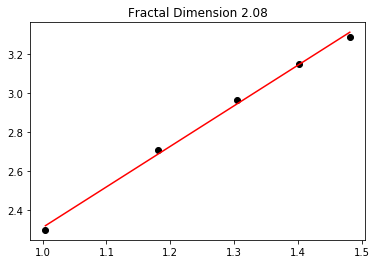

In [7]:
# Values for leath cluster
N = 101
p = 0.65

# Initialize a leath cluster
leath = Leath(N, p=p, animate=False)

# Initialize fit and simulation values
max_clusters = 5
cluster_no = 0
no_bins = 5
bin_count = np.zeros(no_bins, dtype=np.int32)
bin_edges = np.zeros([max_clusters, no_bins+1], dtype=np.float32)
min_size = 0.15 * N/2
max_size = 0.65 * N/2

# Grow total_clusters Different Clusters
while cluster_no < max_clusters:
    # run a Leath simulation
    leath.simulate()
    while not leath.reached_end:
        leath.simulate()
    # Compute distance from center of mass, and add distances to a histogram
    radii = leath.distance_from_center_of_mass()
    cnt, bin_edges[cluster_no, :] = np.histogram(radii, bins=no_bins, range=(min_size, max_size))
    bin_count += np.cumsum(cnt)

    cluster_no += 1

# Take the average count and bin centers across all clusters
avg_bin_count = bin_count / max_clusters
avg_bin_edge = np.mean(bin_edges, 0)
avg_bin_mid = (avg_bin_edge[1:] + avg_bin_edge[0:-1]) / 2

# Fit a line to the r and M(r) data
fit = linregress(np.log10(avg_bin_mid), np.log10(avg_bin_count))
x = np.linspace(np.log10(avg_bin_mid[0]), np.log10((avg_bin_mid[-1])), 1000)
y = fit.slope * x + fit.intercept

# Plot r vs. M(r), as well as slope/intercept of the fitted line
fig = plt.figure()
im = plt.plot(np.log10(avg_bin_mid), np.log10(avg_bin_count), 'ko', x, y, 'r-')
plt.title(f'Fractal Dimension {fit.slope:4.2f}')
plt.show()

### Repeat for p = 0.80 ###

**Q)** Is a spanning cluster generated at p > p_c a fractal? 

**A)** As the value for $p$ approaches 1, the spanning cluster becomes less of a cluster. Even for $p=0.8$ The cluster grows in a linear fashion, so I would say that no it is no longer a fractal.  

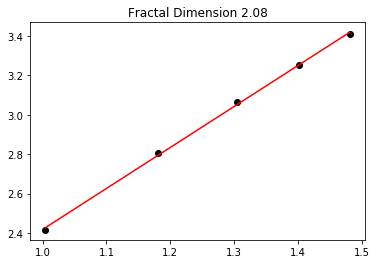

In [8]:
# Values for leath cluster
N = 101
p = 0.8

# Initialize a leath cluster
leath = Leath(N, p=p, animate=False)

# Initialize fit and simulation values
max_clusters = 5
cluster_no = 0
no_bins = 5
bin_count = np.zeros(no_bins, dtype=np.int32)
bin_edges = np.zeros([max_clusters, no_bins+1], dtype=np.float32)
min_size = 0.15 * N/2
max_size = 0.65 * N/2

# Grow total_clusters Different Clusters
while cluster_no < max_clusters:
    # run a Leath simulation
    leath.simulate()
    while not leath.reached_end:
        leath.simulate()
    # Compute distance from center of mass, and add distances to a histogram
    radii = leath.distance_from_center_of_mass()
    cnt, bin_edges[cluster_no, :] = np.histogram(radii, bins=no_bins, range=(min_size, max_size))
    bin_count += np.cumsum(cnt)

    cluster_no += 1

# Take the average count and bin centers across all clusters
avg_bin_count = bin_count / max_clusters
avg_bin_edge = np.mean(bin_edges, 0)
avg_bin_mid = (avg_bin_edge[1:] + avg_bin_edge[0:-1]) / 2

# Fit a line to the r and M(r) data
fit = linregress(np.log10(avg_bin_mid), np.log10(avg_bin_count))
x = np.linspace(np.log10(avg_bin_mid[0]), np.log10((avg_bin_mid[-1])), 1000)
y = fit.slope * x + fit.intercept

# Plot r vs. M(r), as well as slope/intercept of the fitted line
fig = plt.figure()
im = plt.plot(np.log10(avg_bin_mid), np.log10(avg_bin_count), 'ko', x, y, 'r-')
plt.title(f'Fractal Dimension {fit.slope:4.2f}')
plt.show()

### For L = 101, what is the Fractal Dimension of the DLA cluster? ###

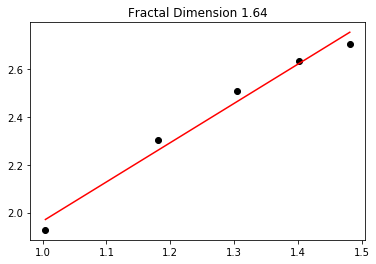

In [15]:
# Values for DLA cluster
N = 101

# Initialize a DLA cluster
dla = DLA(N)

# Initialize fit and simulation values
max_clusters = 5
cluster_no = 0
no_bins = 5
bin_count = np.zeros(no_bins, dtype=np.int32)
bin_edges = np.zeros([max_clusters, no_bins+1], dtype=np.float32)
min_size = 0.15 * N/2
max_size = 0.65 * N/2

# Grow total_clusters Different Clusters of lattice size 300 with at least N_min particles
while cluster_no < max_clusters:
    # run a DLA simulation
    dla.simulate()
    
    # Compute distances from center of mass and make a histogram of distances
    radii = dla.distance_from_center_of_mass()
    cnt, bin_edges[cluster_no, :] = np.histogram(radii, bins=no_bins, range=(min_size, max_size))
    bin_count += np.cumsum(cnt)

    cluster_no += 1

# Take the average count and bin centers across all clusters
avg_bin_count = bin_count / max_clusters
avg_bin_edge = np.mean(bin_edges, 0)
avg_bin_mid = (avg_bin_edge[1:] + avg_bin_edge[0:-1]) / 2

# Fit a line to the r and M(r) data
fit = linregress(np.log10(avg_bin_mid), np.log10(avg_bin_count))
x = np.linspace(np.log10(avg_bin_mid[0]), np.log10((avg_bin_mid[-1])), 1000)
y = fit.slope * x + fit.intercept

# Plot r vs. M(r), as well as slope/intercept of the fitted line
fig = plt.figure()
im = plt.plot(np.log10(avg_bin_mid), np.log10(avg_bin_count), 'ko', x, y, 'r-')
plt.title(f'Fractal Dimension {fit.slope:4.2f}')
plt.show()